[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task2_dmrf_visual.ipynb)

# Задание
* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить результаты в pandas dataframe
<hr>

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных:
-- Привести колонки датафрейма к одному типу данных
-- Проверить индекс, чтобы он соответствовал порядку строк
-- Проверить наличие пропусков и в случае обнаружения, определить стратегию их обработки
<hr>

* Провести мини-исследование рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.
-- Рассчитать средние цены за квадратный метр по регионам. Важно чтобы пропуски не учитывались при расчете средней цены.
-- Рассчитать объемы вводимого жилья по регионам и по годам.
-- Сравнить этажность домов, количество квартир, жилую площадь, количество парковочных мест и цену за квадратный метр в разных регионах
-- Визуализировать разброс, связь и распределение этих показателей по регионам
-- Сделать выводы по каждому из расчетов и графиков



In [1]:
import pandas as pd
import requests

## Список объектов

In [2]:
#начальное смещение
offset_ = 0

#кол-во записей для загрузки за один запрос
limit_ = 1000

res = []
#загружаем частями все id объектов и формируем результирующий список
while 1==1: 
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
    temp = requests.get(url).json().get('data').get('list')
    
    if len(temp) :        
        objids = [x.get('objId') for x in temp]
        res += objids
        offset_ += limit_
    else:
        print('loaded : ' + str(offset_) + ' records')
        break

loaded : 11000 records


In [18]:
#Загрузка данных по списку объектов

objlist = []
cnt = 0
for el in res:
    url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{el}'
    x = requests.get(url).json().get('data')
    objlist.append(x)


df = pd.concat([ pd.json_normalize(i) for i in objlist], ignore_index=True)

In [21]:
#выгрузим в pickle
df.to_pickle('./house_data.pkl')

## Обработка датафрейма и выбор колонок для анализа

In [ ]:
#объекты были сохранены ранее 
#достаем из сохраненного файлв датафрейм
df = pd.read_pickle('house_data.pkl')

In [117]:
#  выберем колонки по которым будем проводить исследование
col_for_analize = ['region',
                    'objElemLivingCnt', 
                    'objReady100PercDt', 
                    'objElemParkingCnt',
                    'objSquareLiving', 
                    'objFlatCnt', 
                    'objFlatSq', 
                    'objFloorCnt', 
                    'soldOutPerc',
                    'objPriceAvg',
                    ]

In [96]:
df1 = df[col_for_analize]

In [99]:
# стратегия заполнения пропущенных значений. заполним нулями
df1 = df1.fillna(0)

In [103]:
# приведем типы колонок к единому формату .  для даты 100 процентой готовности укадем дату
col_types = {'region' : 'int32' ,
             'objElemLivingCnt' : 'int32' ,
             'objReady100PercDt' : 'datetime64', 
             'objElemParkingCnt' : 'int32',
             'objSquareLiving' : 'float64', 
             'objFlatCnt' : 'int32', 
             'objFlatSq' : 'float64', 
             'objFloorCnt' : 'int32', 
             'soldOutPerc' : 'float64',
             'objPriceAvg' : 'float64'
             }
             
df1 = df1.astype(col_types)

In [223]:
# дабавим несколько колонок 

df1['ready_year'] = df1['objReady100PercDt'].apply( lambda x : x.year)
df1['avg_sqr'] = df1['objFlatSq'] / df1['objFlatCnt']

## Исследование и анализ датафрейма

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
#расчет средней цены по регионам

avg_price = df1.where(df1['objPriceAvg'] > 0)[['region', 'objPriceAvg']].groupby('objPriceAvg').agg('mean')

In [146]:
avg_price = df1[df1['objPriceAvg'] > 0][['region', 'objPriceAvg']].groupby('objPriceAvg').agg('mean')

In [225]:
df2 = df1[df1['objPriceAvg'] > 0]

In [226]:
df2['objProce'] = df2['objPriceAvg'] * df2['objFlatSq']

/tmp/ipykernel_146052/1708171405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['objProce'] = df2['objPriceAvg'] * df2['objFlatSq']


In [227]:
df3 = df2[['region','objFlatSq','objProce']].groupby(['region']).aggregate({'objFlatSq' : 'sum', 'objProce' : 'sum'})

In [172]:
%matplotlib inline


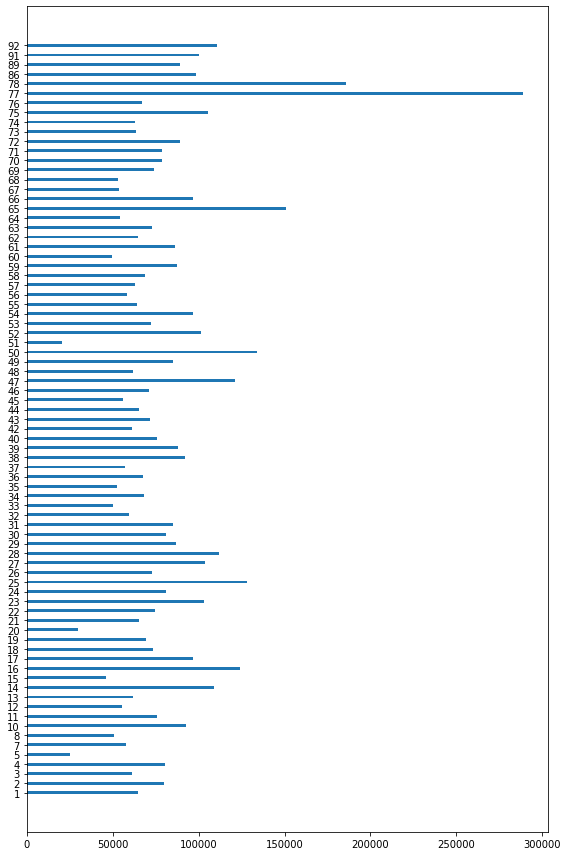

In [205]:

plt.rcParams.update({'figure.autolayout': True})
fig , ax = plt.subplots(figsize = (8,12))

for_bar = (df3['objProce'] / df3['objFlatSq'])

cat = [ str(x) for x in for_bar.index ]

plt.barh( cat , for_bar.values , height=0.3 )
plt.show()

In [229]:
# ввод жилья по регионам .
by_year = df2[['ready_year','objSquareLiving']].groupby(['ready_year']).agg('sum')

In [233]:
x_ticks = [ str(x) for x in by_year.index ]

<BarContainer object of 15 artists>

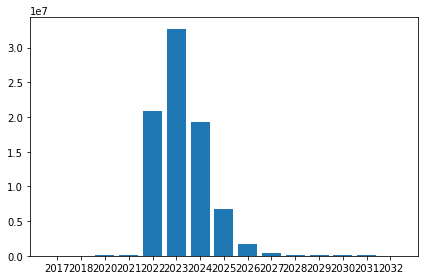

In [238]:
plt.bar(x_ticks, by_year['objSquareLiving'])

## Выводы 
### Самые высокие цены  77, 78 регионы
### Пик ввода жилья придется на 2023 год